## Modelo Precios: Predicción en Producción

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import load

## Ejecución de las clases creadas para CARGAR el modelo correctamente
- si no no encuentra los atributos de la clase

In [ ]:
# --- Transformer para eliminar columnas ---
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns, errors="ignore")

# --- Transformer para feature engineering ---
class FeatureBuilderPriceFixed(BaseEstimator, TransformerMixin):
    """
    Transformer SIN fit (stateless):
    - Valida columnas requeridas
    - Crea variables adicionales:
      Variac_Temp, Gen_E_Relat, Gen_S_Relat,
      IndiceGas (base fija), time_idx, sin_doy, cos_doy
    """
    def __init__(
        self,
        precio_base_gas: float = 47.66,   # valor fijo (evita fit); se puede modificar
        temp_ref: float = 16.0,
        sort: bool = True
    ):
        self.precio_base_gas = float(precio_base_gas)
        self.temp_ref = temp_ref
        self.sort = sort

        self.required_columns_ = [
            "Year", "Month", "Day", "DayOfYear",
            "Demanda_GWh", "Gen_Eolica_GWh", "Gen_Solar_GWh",
            "Temp_media_C_Nat", "Price_Gas_EUR_MWh",
            "Pot_Eolica_GW", "Pot_Solar_GW",
            "Temp_min_C_Nat", "Temp_max_C_Nat",
            "RadiacionGlobal_media_Wm2_Nat", "Viento_media_ms_Nat",
            "festivo", "IPC Diario",
        ]

    def fit(self, X, y=None):
        # No aprende nada. Se deja por compatibilidad con sklearn.
        if not np.isfinite(self.precio_base_gas) or self.precio_base_gas == 0:
            raise ValueError("precio_base_gas debe ser un número finito y distinto de 0.")
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Este transformer espera un pandas.DataFrame como entrada.")

        missing = [c for c in self.required_columns_ if c not in X.columns]
        if missing:
            raise ValueError(f"Faltan columnas requeridas en el input: {missing}")

        df = X.copy()

        if self.sort:
            df = df.sort_values(["Year", "Month", "Day"]).reset_index(drop=True)

        # Nuevas variables
        df["Variac_Temp"] = (df["Temp_media_C_Nat"] - self.temp_ref).abs()

        denom = df["Demanda_GWh"].replace(0, np.nan)
        df["Gen_E_Relat"] = df["Gen_Eolica_GWh"] / denom
        df["Gen_S_Relat"] = df["Gen_Solar_GWh"] / denom

        # Índice del gas con base fija
        df["IndiceGas"] = (df["Price_Gas_EUR_MWh"] / self.precio_base_gas) * 100

        # Variables temporales
        df["time_idx"] = np.arange(len(df), dtype=int)
        df["sin_doy"] = np.sin(2 * np.pi * df["DayOfYear"] / 365.25)
        df["cos_doy"] = np.cos(2 * np.pi * df["DayOfYear"] / 365.25)

        return df

    # ---------- helpers ----------
    def _check_required_columns(self, X: pd.DataFrame):
        missing = [c for c in self.required_columns_ if c not in X.columns]
        if missing:
            raise ValueError(f"Faltan columnas requeridas en el input: {missing}")

    @staticmethod
    def _ensure_df(X):
        if isinstance(X, pd.DataFrame):
            return X
        raise TypeError("Este transformer espera un pandas.DataFrame como entrada.")

## CARGA DE DATOS RAW

### Las VARIABLES RAW que alimentan el modelo de Precios son las siguientes (valores horarios)
Data columns (total 17 columns):

| #  | Columna                          | Non-Null Count | Tipo de dato |
|----|----------------------------------|----------------|--------------|
| 0  | Year                             | 1826           | int64        |
| 1  | Month                            | 1826           | int64        |
| 2  | Day                              | 1826           | int64        |
| 3  | DayOfYear                        | 1826           | int64        |
| 4  | Demanda_GWh                      | 1826           | float64     |
| 5  | Gen_Eolica_GWh                   | 1826           | float64     |
| 6  | Gen_Solar_GWh                    | 1826           | float64     |
| 7  | Pot_Eolica_GW                    | 1826           | float64     |
| 8  | Pot_Solar_GW                     | 1826           | float64     |
| 10 | Temp_min_C_Nat                   | 1826           | float64     |
| 11 | Temp_max_C_Nat                   | 1826           | float64     |
| 12 | Temp_media_C_Nat                 | 1826           | float64     |
| 13 | RadiacionGlobal_media_Wm2_Nat     | 1826           | float64     |
| 14 | Viento_media_ms_Nat              | 1826           | float64     |
| 15 | Price_Gas_EUR_MWh                | 1826           | float64     |
| 16 | festivo                          | 1826           | int64        |
| 17 | IPC Diario                       | 1826           | float64     |

In [3]:
input_raw_df=pd.read_csv("SET_INPUTS_BASE_2_Cliente.csv", encoding='latin1')
input_raw_df.drop(columns=["Price_Elec_EUR_MWh"], inplace=True)

## Predicción : carga de modelo y predicción

In [5]:
production_pipe = load("modelo_precio_electricidad_prod_HGB.joblib")

def predict_price(input_raw: pd.DataFrame, production_pipe) -> np.ndarray:
    """
    Predice el precio eléctrico a partir de datos raw.
    input_raw: DataFrame con las columnas originales
    """
    return production_pipe.predict(input_raw)

y_pred = predict_price(input_raw_df, production_pipe)

# Gráfica de la predicción

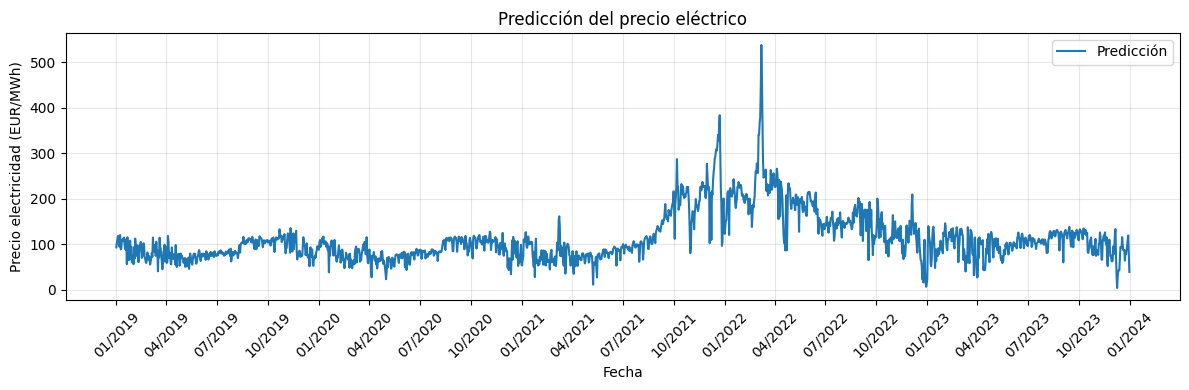

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------------------------
# 1) DataFrame para la gráfica
# -------------------------
df_plot = input_raw_df.copy()

df_plot["Fecha"] = pd.to_datetime(
    dict(year=df_plot["Year"], month=df_plot["Month"], day=df_plot["Day"])
)

df_plot["y_pred"] = y_pred

df_plot = df_plot.sort_values("Fecha").reset_index(drop=True)

# -------------------------
# 2) Gráfica
# -------------------------
plt.figure(figsize=(12, 4))
plt.plot(df_plot["Fecha"], df_plot["y_pred"], label="Predicción")

plt.xlabel("Fecha")
plt.ylabel("Precio electricidad (EUR/MWh)")
plt.title("Predicción del precio eléctrico")

# Resolución trimestral (cada 3 meses)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.10.post3
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.3
aiosignal                                1.4.0
aiosqlite                                0.22.1
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.18.1
altair                                   5.5.0
annotated-doc                            0.0.4
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                         